In [307]:
import os
import re
import pickle
import tqdm
import pandas as pd
import numpy as np
import random
import glob
import datetime
import scipy
from numpy import matlib
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import warnings
from copy import deepcopy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from utils import decoy_subject, rdms
import importlib

In [191]:
SUBJECTS = glob.glob('./ev_data/*ev_ids.csv')
SUBJECTS = [re.findall(r'(\d+)_ev_ids.csv', s)[0] for s in SUBJECTS]
SUBJECTS = sorted(SUBJECTS)
# remove 006 because of artifacts in all task scans
SUBJECTS.remove('006')

In [192]:
SET_NUMBERS = np.arange(1, 28)
LOTTERY_IDS = np.arange(1, 32)
lotteries = pd.read_csv('../../psychopy_version/part1/stimuli/evaluation_stimuli_v3_psychopy.csv')
rois = ['vmPFC', 'vSTR', 'PCC', 'M1', 'ACC', 'V1', 'EC']
eval_stimuli = pd.read_csv('../../stimuli/evaluation_stimuli_v3.csv')
eval_stimuli.loc[:, 'EV'] = eval_stimuli.prob * eval_stimuli.amount / 100
evs = eval_stimuli.EV.values.flatten()
amounts = eval_stimuli.amount.values.flatten()
probs = eval_stimuli.prob.values.flatten()
set_ids = eval_stimuli[['lottery_id', 'set']]
option_letters = ['A', 'B', 'C']
set_dicts = {}
set_ids_lists = [this_set_id.split(',') for this_set_id in set_ids.set]
for set_num in SET_NUMBERS:
    set_dict = {}
    for letter in option_letters:
        option_str = str(set_num) + letter
        option_str_bool = [option_str in set_id_list for set_id_list in set_ids_lists]
        option_str_id = set_ids.loc[option_str_bool, 'lottery_id'].values[0]
        set_dict[letter] = option_str_id
    set_dicts[set_num] = set_dict

In [193]:
lottery_objs = []
for i, lottery_row in lotteries.iterrows():
    l = decoy_subject.Lottery(lottery_row.lottery_id, lottery_row.amount, lottery_row.prob)
    lottery_objs.append(l)

In [194]:
# behavior_results = pd.read_csv('../../results/pilot_v2/pilot2_results_with_stimuli_control_for_decoy_choice.csv', index_col=0)
# behavior_results = pd.read_csv('../../results/preregister_results/decoy_table_n85.csv', index_col=0)
# behavior_results = pd.read_csv('../../results/preregister_results/decoy_table_n80.csv', index_col=0)
# behavior_results = pd.read_csv('../../results/preregister_results/decoy_table_n145.csv', index_col=0)
behavior_results = pd.read_csv('../../results/preregister_results/decoy_table_lab_n122.csv', index_col=0)

In [308]:
importlib.reload(decoy_subject)
set_objs = np.zeros(len(set_dicts), dtype=object)
for i, set_num in enumerate(set_dicts.keys()):
    set_dict = set_dicts[set_num]
    target_id = set_dict['A'] - 1
    competitor_id = set_dict['B'] - 1
    decoy_id = set_dict['C'] - 1
    target = lottery_objs[target_id]
    competitor = lottery_objs[competitor_id]
    decoy = lottery_objs[decoy_id]
    decoy_effect = behavior_results.loc[set_num, 'decoy_effect_A']
    target_ratio_binary = behavior_results.loc[set_num, 'A_ratio_binary']
    target_ratio_ternary = behavior_results.loc[set_num, 'A_ratio_trinary']
    s = decoy_subject.Set(set_num, target, competitor, decoy, decoy_effect, target_ratio_binary, target_ratio_ternary)
    set_objs[i] = s

In [173]:
with open('./objects/subjects_1_31_MSM.pkl', 'rb') as f:
    subjects = pickle.load(f)

In [176]:
# subject_merged_stats = pd.DataFrame()
# for subject in subjects:
#     subject_stats = pd.Series(subject.num_missed)
#     subject_merged_stats = pd.concat([subject_merged_stats, subject_stats], axis=0)
# plt.figure(figsize=(8, 6), dpi=150)
# plt.hist(subject_merged_stats, color='pink')
# plt.vlines(155*0.3, 0, 14, color='grey', linestyle='--')
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.xlabel('Missed trials', fontsize=24)
# plt.ylabel('Frequency', fontsize=24)
# plt.title('Missed trials distribution', fontsize=32)


In [7]:
# importlib.reload(decoy_subject)
# subjects = []
# info_survey = pd.read_csv('../../results/preregister_results/survey_details.csv', index_col=0)
# for sub_num in SUBJECTS:
#     if sub_num=='002':
#         runs = np.array([1, 3, 4, 5])
#     elif sub_num=='009':
#         runs = np.array([1, 2, 3, 4])
#     elif sub_num=='022':
#         runs = np.array([2, 3, 4, 5])
#     else:
#         runs = np.arange(1, 6)
#     age = info_survey.loc[info_survey.UID==int(sub_num), 'Age']
#     female = info_survey.loc[info_survey.UID==int(sub_num), 'Female']
#     right_hand = info_survey.loc[info_survey.UID==int(sub_num), 'RightHanded']
#     subject = decoy_subject.Subject(sub_num, age=age, female=female, right_hand=right_hand, runs=runs)
#     # subject.calc_RDM(mask_dict_type='schaefer', motion_thresh=0.75, verbose=True)
#     subjects.append(subject)

In [177]:
# def calc_RDM(subject, mask_dict_type='roi', motion_thresh=0.75):
#     subject.calc_RDM(mask_dict_type=mask_dict_type, motion_thresh=motion_thresh, verbose=False)
#     return subject
# subjects_calced = Parallel(n_jobs=-1)(delayed(calc_RDM)(subject, 'roi') for subject in tqdm.tqdm(subjects))
# subjects = subjects_calced

In [9]:
with open('./objects/subjects_1_31_MSM.pkl', 'wb') as f:
    pickle.dump(subjects, f)

In [178]:
subjects_missed_filtered = [subject for subject in subjects if subject.num_missed < 155*0.3]

In [179]:
# roi = 'vmPFC'
# subject_len = len(subjects)
# n_cols = 6
# n_rows = int(np.ceil(subject_len / n_cols))
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 18), sharex=True, dpi=150)
# i = 0
# j = 0
# for subject in subjects:
#     big_rdm = subject.RDM[roi]
#     image = axs[i, j].imshow(big_rdm, cmap='Purples')
#     axs[i, j].set_yticks(np.arange(len(LOTTERY_IDS), step=2), LOTTERY_IDS[::2], fontsize=8)
#     axs[i, j].set_title(f'{subject.sub_num}, {roi}', fontsize=10)
#     plt.colorbar(image, ax=axs[i, j])
#     if i == n_rows:
#         axs[i, j].set_xticks(np.arange(len(LOTTERY_IDS), step=2), LOTTERY_IDS[::2], fontsize=8, rotation=90)
#     else:
#         axs[i, j].xaxis.set_ticks_position('none')
#     i = (i + 1) if j == n_cols-1 else i
#     j = (j + 1) % n_cols

In [306]:
len(test_sets)

1

In [305]:
len(train_sets)

26

In [310]:
rois = ['vmPFC', 'PCC', 'M1', 'ACC', 'V1', 'EC', 'vSTR']
# rois = ['whole_brain']
test_rmse = np.zeros(len(set_objs))
test_mse = np.zeros(len(set_objs))
scaler = StandardScaler()
for i, set_out in enumerate(set_objs):
    print(f'Set {set_out.set_num} is out')
    test_sets = []
    train_sets = []
    set_objs_copy = deepcopy(set_objs)
    train_sets = np.delete(set_objs_copy, i)
    test_sets.append(set_out)
    # for s in set_objs_copy:
    #     overlap_with_test = s.overlapping_with(set_out)
    #     if overlap_with_test:
    #         test_sets.append(s)
    #     if not overlap_with_test:
    #         train_sets.append(s)
    y_test = np.array([s.decoy_effect for s in test_sets])
    y_train = np.array([s.decoy_effect for s in train_sets])
    # y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    # y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()
    # for j, train_set in enumerate(train_sets):
    #     train_sets[j].decoy_effect = y_train[j]
    # for j, test_set in enumerate(test_sets):
    #     test_sets[j].decoy_effect = y_test[j]
    _, selected_rois = first_stepwise(rois, subjects_missed_filtered, verbose=False)
    print(f'Selected rois: {selected_rois}')
    rdm_reg = decoy_subject.RDMRegression(subjects=subjects_missed_filtered, rois=selected_rois, sets=train_sets)
    rdm_reg.fit()
    print(f'Train R2-adj: {rdm_reg.adj_r2:.4f}, (p={rdm_reg.pval:.5f})')
    y_train_pred = rdm_reg.lm.predict(rdm_reg.X_for_lm)
    print(f'Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}')
    y_pred, _ = rdm_reg.predict(test_sets)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'Test MSE: {mse:.4f}')
    test_rmse[i] = rmse
    test_mse[i] = mse
cv_rmse = np.mean(test_rmse)
cv_mse = np.mean(test_mse)
print(f'CV MSE: {cv_mse:.4f}')
print(f'CV RMSE: {cv_rmse:.4f}')

Set 1 is out


In [180]:
def save_model_pvalues(model):
    alpha_enter = 0.05
    alpha_remove = 0.05
    model_rois = model.lm.pvalues.index.str.split('_').str[0]
    model_rois = model_rois[1:] # ignore the intercept
    model_pvalues = model.lm.pvalues[1:] # ignore the intercept
    model_sig_p = model_pvalues < alpha_enter
    model_p_df = pd.DataFrame({'p_val':model_pvalues, 'significant':model_sig_p, 'roi':model_rois}, index=model_pvalues.index)
    model_p_df.set_index(['roi', model_p_df.index], inplace=True)
    return model_p_df

In [181]:
def stepwise(model, rois, subjects, step_i=2, verbose=False):
    if len(rois)==0:
        return model
    else:
        pvals_sig = np.zeros(len(rois))
        avg_minus_log_p = np.zeros(len(rois))
        if verbose:
            print('-----')
            print(f'Step {step_i}')
            print(f'Current model uses: {model.rois}')
            print(f'Testing: {rois}')
        model_rois = model.rois.copy()
        for i, roi in enumerate(rois):
            current_rois = np.append(model_rois, roi)
            rdm_reg = decoy_subject.RDMRegression(subjects=subjects, rois=current_rois, sets=set_objs)
            rdm_reg.fit()
            #   save all p-values 
            rdm_reg_pvals = save_model_pvalues(rdm_reg)
            roi_sig = rdm_reg_pvals.loc[pd.IndexSlice[roi, :], 'significant']
            roi_pvals = rdm_reg_pvals.loc[pd.IndexSlice[roi, :], 'p_val']
            pvals_sig[i] = np.sum(roi_sig)
            avg_minus_log_p[i] = np.mean(-np.log10(roi_pvals))    
        #   compare which ROI has best p-values
        pvals_df = pd.DataFrame({'roi':rois, 'pvals_sig':pvals_sig, 'avg_minus_log_p':avg_minus_log_p})
        pvals_df = pvals_df.sort_values(by=['pvals_sig', 'avg_minus_log_p'], ascending=False)
        #   choose best ROI
        best_roi = pvals_df.roi.values[0]
        best_pval = pvals_df.pvals_sig.values[0]
        if verbose:
            print(f'Best ROI: {best_roi}, # significant p-values is {best_pval}, average -log(p-value): {pvals_df.avg_minus_log_p.values[0]}')
        if best_pval < 1:
            if verbose:
                print(f'Stopping stepwise as best ROI has <1 significant p-values')
        else:
            if verbose:
                print(f'Refitting model with {best_roi}')
            rois.remove(best_roi)
            model_rois = model.rois
            model_rois = np.append(model_rois, best_roi)
            new_model = decoy_subject.RDMRegression(subjects=subjects, rois=model_rois, sets=set_objs)
            new_model.fit()
            #   test other ROIs in the chosen model
            model_pvals = save_model_pvalues(new_model)
            #   remove ROIs with p > alpha_remove
            model_sig = model_pvals.groupby('roi').sum().significant
            surviving_rois = model_sig[model_sig>0].index.values
            if verbose:
                print(f'Surviving ROIs after addition of {best_roi}: {surviving_rois}')
            removed_rois = model_sig[model_sig==0].index.values.tolist()
            rois = rois + removed_rois
            model = decoy_subject.RDMRegression(subjects=subjects, rois=surviving_rois, sets=set_objs)
            model.fit()
            model = stepwise(model, rois, subjects, step_i+1, verbose=verbose)
    
        return model

In [182]:
def first_stepwise(rois, subjects, verbose=False):
    if verbose:
        print('first step of stepwise regression')
    first_model_ps = np.zeros(len(rois))
    for i, roi in enumerate(rois):
        rdm_reg = decoy_subject.RDMRegression(subjects=subjects, rois=[roi], sets=set_objs)
        rdm_reg.fit()
        first_model_ps[i] = rdm_reg.pval
    if len(first_model_ps) == 0:
        best_first_roi = None
        return None, None
    else:
        best_first_roi = rois[np.argmin(first_model_ps)]
    if verbose:
        print(f'Best first ROI: {best_first_roi}')
    model = decoy_subject.RDMRegression(subjects=subjects, rois=[best_first_roi], sets=set_objs)
    model.fit()
    rois.remove(best_first_roi)
    if verbose:
        print(f'Continue with: {rois}')
    final_model = stepwise(model, rois, subjects, step_i=2, verbose=verbose)
    if verbose:
        print('*******')
        print(f'Final model uses: {final_model.rois}')
    return final_model, final_model.rois

In [183]:
# ## schaefer / searchlight regressions
# def train_rdm(subjects, rois, sets):
#     rdm_reg = decoy_subject.RDMRegression(subjects=subjects, rois=rois, sets=sets)
#     rdm_reg.fit()
#     return rdm_reg
# rois = list(subjects[0].RDM.keys())
# rdm_array = np.empty(len(rois), dtype=object)
# trained_rdms = Parallel(n_jobs=-1, backend='threading')(delayed(train_rdm)(subjects, [roi], set_objs) for roi in tqdm.tqdm(rois))

In [184]:
# searchlight_r2 = np.array([rdm.adj_r2 for rdm in trained_rdms])
# searchlight_results = pd.DataFrame({'roi':rois, 'r2':searchlight_r2 })
# searchlight_results.loc[:, 'label'] = np.int16(searchlight_results.roi.str.split('_').str[1])
# searchlight_results = searchlight_results.sort_values(by='label')

In [185]:
rois = ['vmPFC', 'PCC', 'M1', 'ACC', 'vSTR', 'V1', 'EC']
stepwise_model, stepwise_rois = first_stepwise(rois, subjects_missed_filtered, verbose=False)
print(f'Selected ROIs: {stepwise_rois}')

first step of stepwise regression
Best first ROI: EC
Continue with: ['vmPFC', 'PCC', 'M1', 'ACC', 'vSTR', 'V1']
-----
Step 2
Current model uses: ['EC']
Testing: ['vmPFC', 'PCC', 'M1', 'ACC', 'vSTR', 'V1']
Best ROI: PCC, # significant p-values is 1.0, average -log(p-value): 0.7583270985035918
Refitting model with PCC
Surviving ROIs after addition of PCC: ['EC' 'PCC']
-----
Step 3
Current model uses: ['EC' 'PCC']
Testing: ['vmPFC', 'M1', 'ACC', 'vSTR', 'V1']
Best ROI: M1, # significant p-values is 1.0, average -log(p-value): 0.6914408185989287
Refitting model with M1
Surviving ROIs after addition of M1: ['EC' 'M1' 'PCC']
-----
Step 4
Current model uses: ['EC' 'M1' 'PCC']
Testing: ['vmPFC', 'ACC', 'vSTR', 'V1']
Best ROI: V1, # significant p-values is 1.0, average -log(p-value): 0.8030051669587929
Refitting model with V1
Surviving ROIs after addition of V1: ['EC' 'M1' 'PCC' 'V1']
-----
Step 5
Current model uses: ['EC' 'M1' 'PCC' 'V1']
Testing: ['vmPFC', 'ACC', 'vSTR']
Best ROI: ACC, # sign

In [293]:
importlib.reload(decoy_subject)
rdm_reg = decoy_subject.RDMRegression(subjects=subjects_missed_filtered, rois=stepwise_rois, sets=set_objs)
rdm_reg.fit()
print(rdm_reg.adj_r2, rdm_reg.pval)
wb_rdm_reg = decoy_subject.RDMRegression(subjects=subjects_missed_filtered, rois=['whole_brain'], sets=set_objs)
wb_rdm_reg.fit()
wb_rdm_reg.adj_r2, wb_rdm_reg.pval

0.6135789402898804 0.00493592893166421


(-0.039257991102355616, 0.5775698357841201)

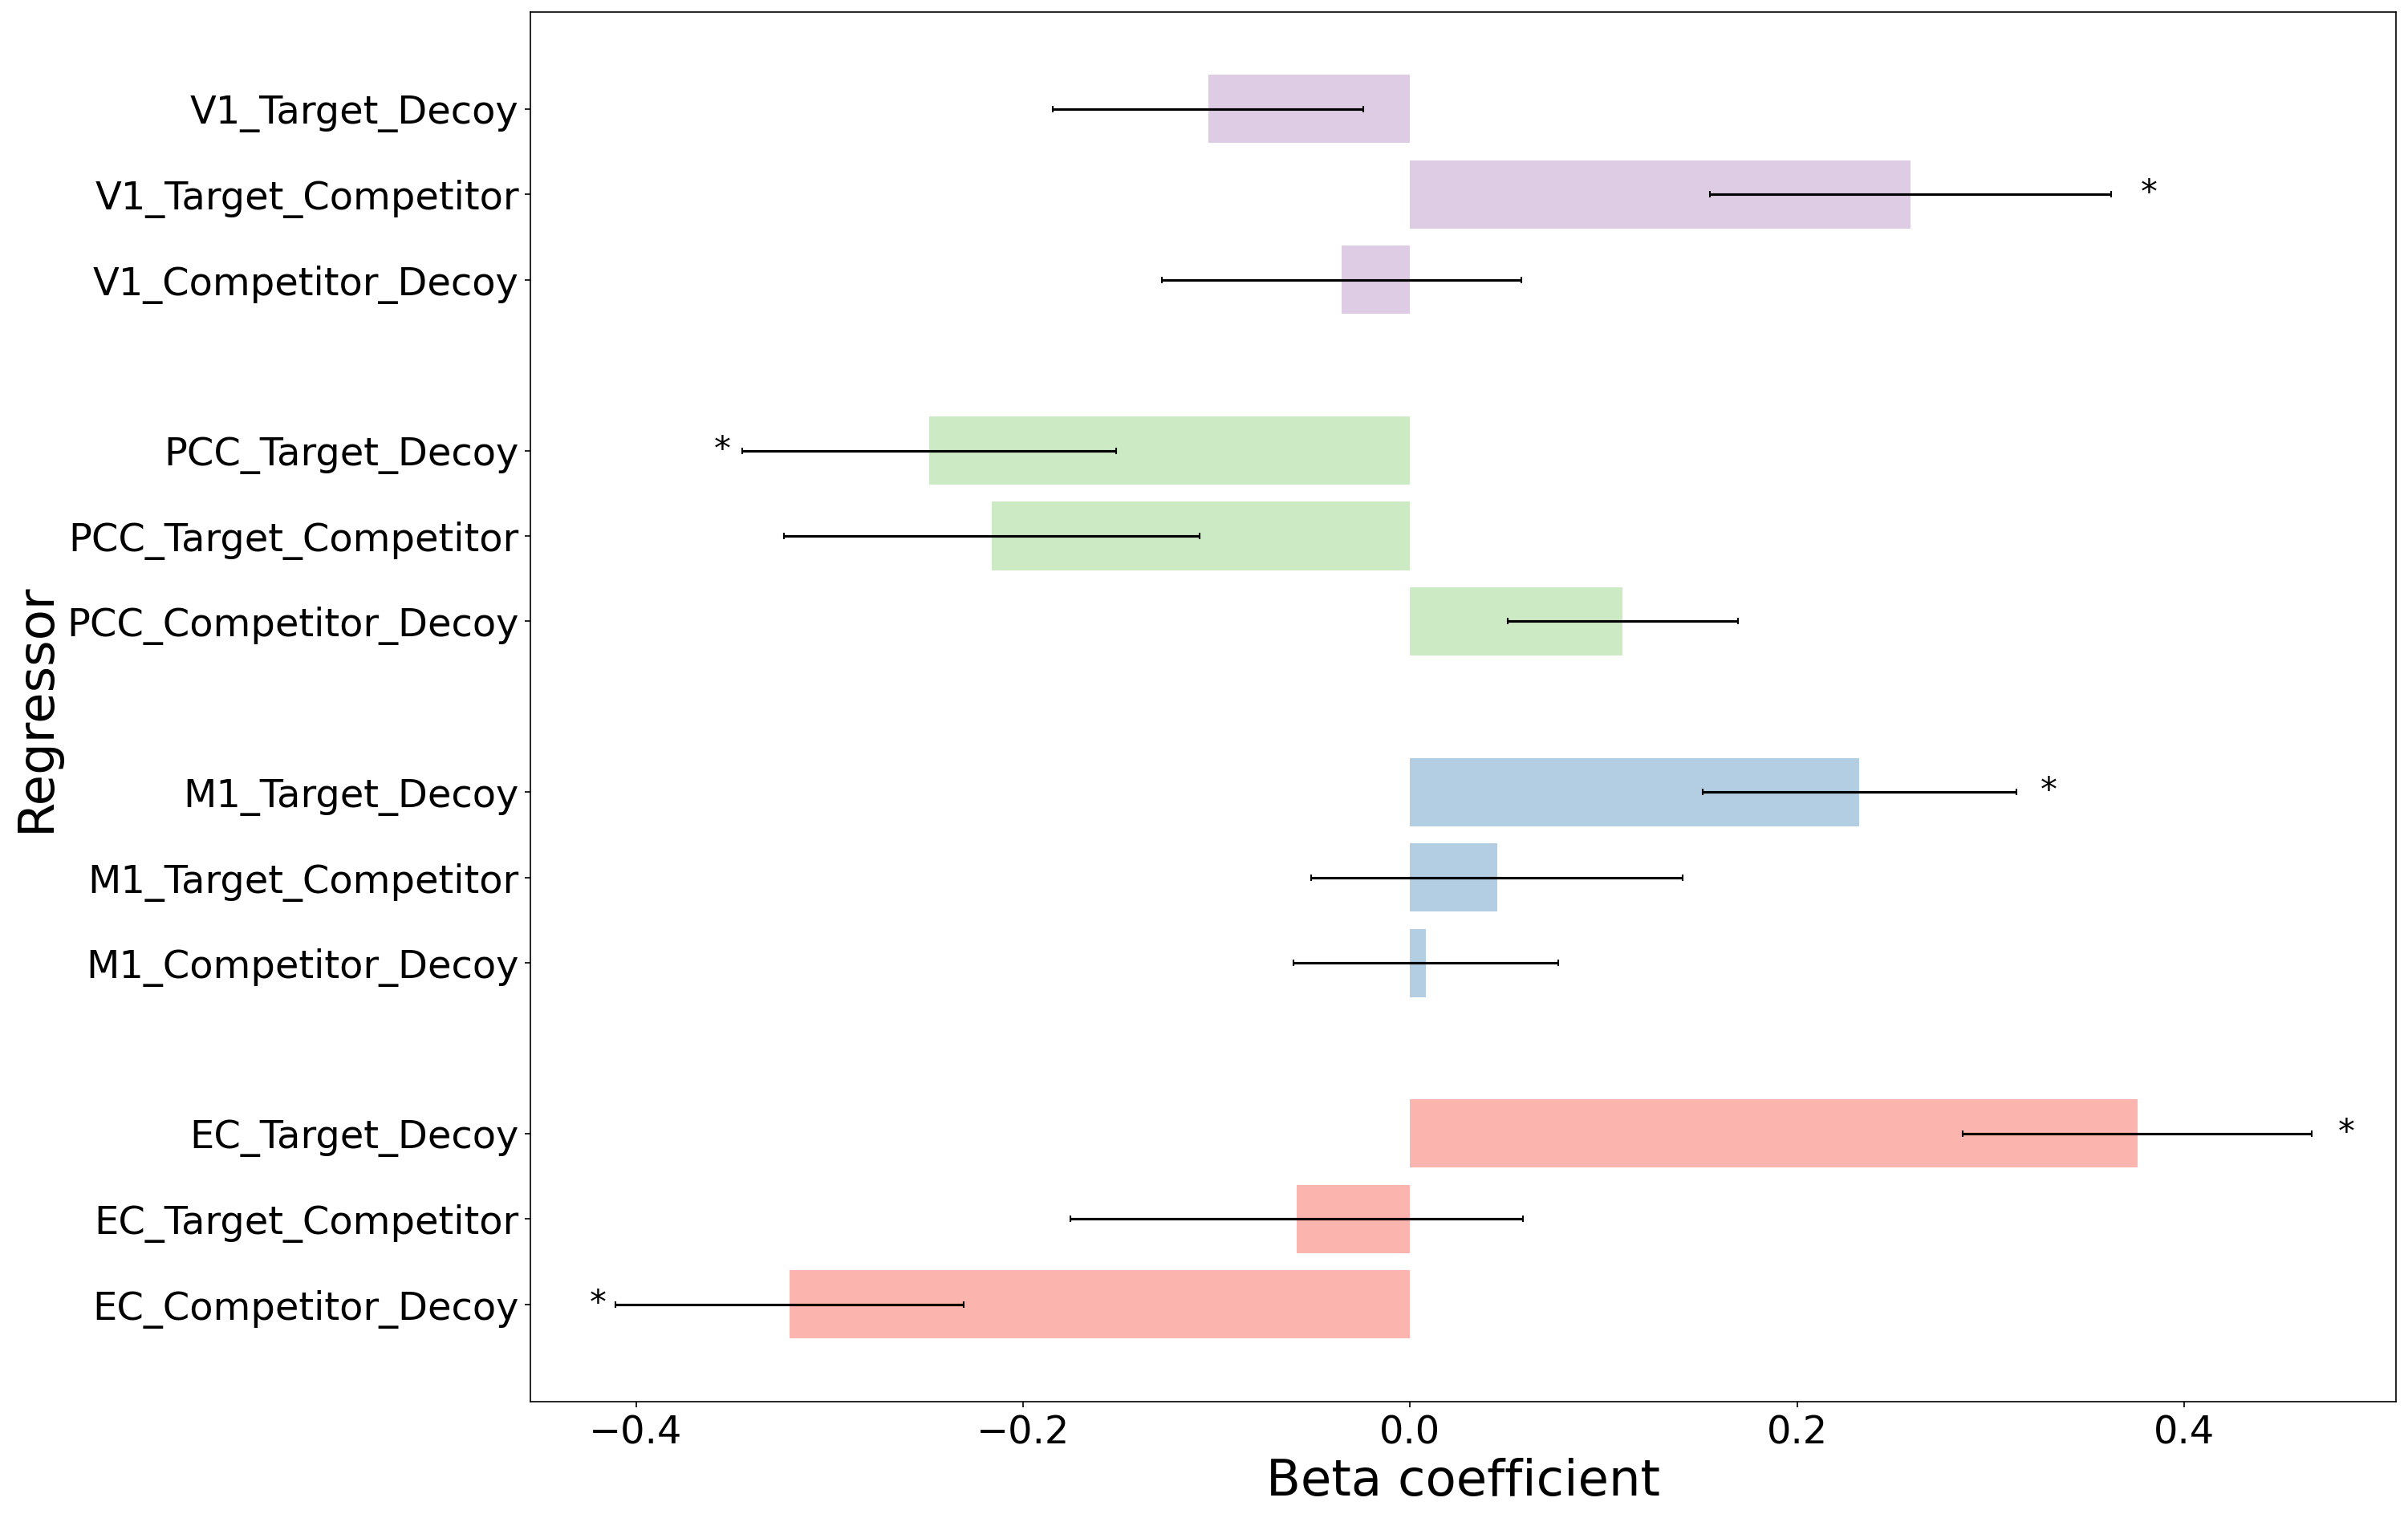

In [294]:
importlib.reload(decoy_subject)
rdm_reg.plot_coefficients()

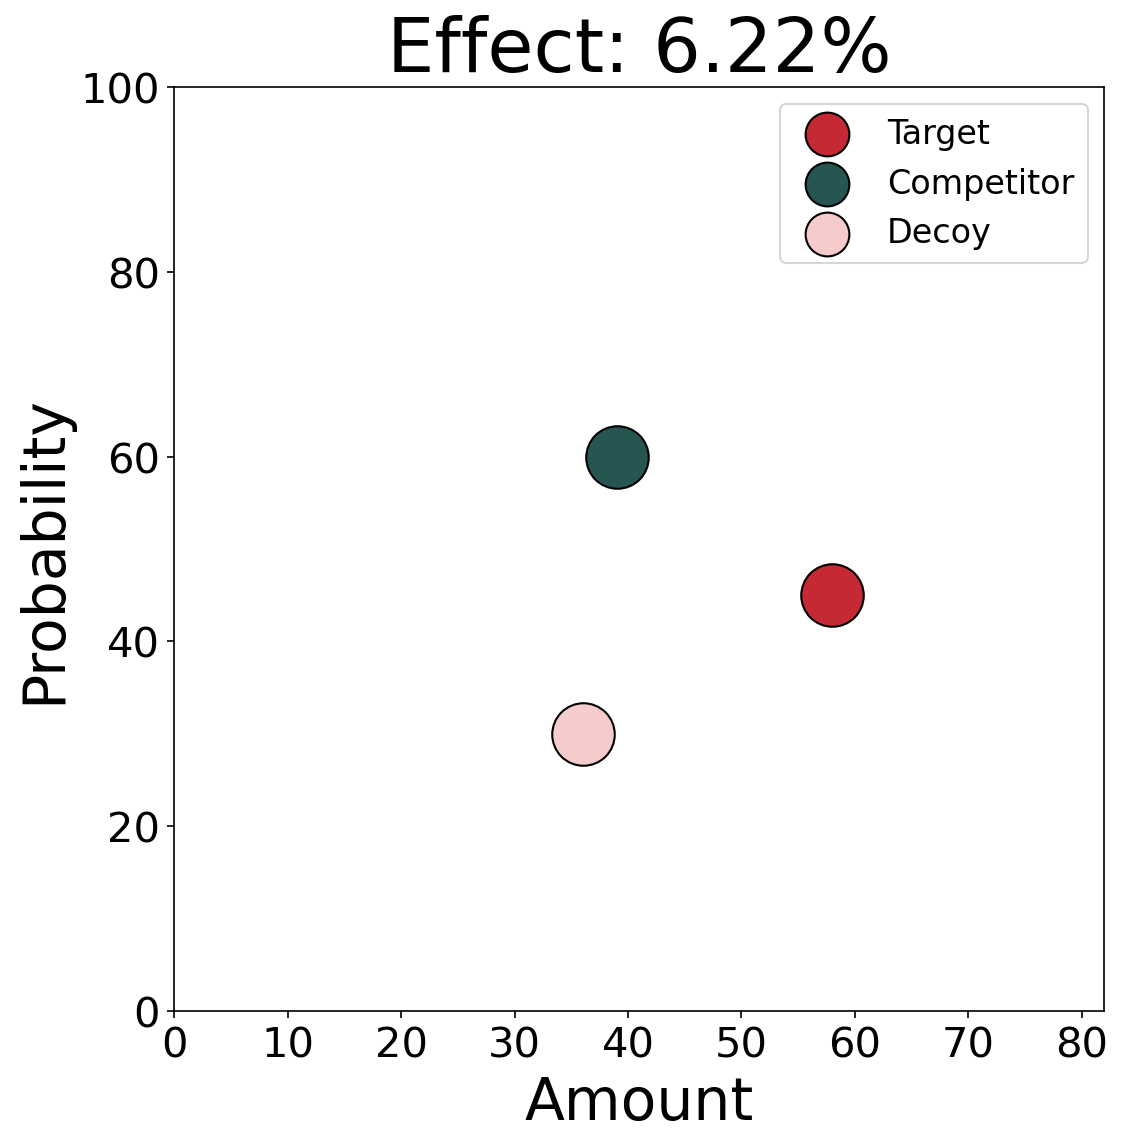

In [47]:
importlib.reload(decoy_subject)
a, b, c = rdm_reg.predict_novel_decoys(set_objs[-3])
c[a.sort_values().index[-1]].plot()

In [281]:
# test how the effect changes as n increases and search for plateau
to_save = True
ns = np.arange(1, len(subjects_missed_filtered)+1, 1)
n_len = len(ns)
B = 100#len(subjects_missed_filtered)
p_arr = np.zeros((B, n_len))
r2_arr = np.zeros((B, n_len))
rois = ['vmPFC', 'PCC', 'M1', 'ACC', 'vSTR', 'V1', 'EC']
i = 0
subjects_shuffled = subjects_missed_filtered.copy()
subsets = np.zeros((n_len, B), dtype=object)
for k in ns:
    subjects_to_draw = k
    for b in range(B):
        random.shuffle(subjects_shuffled)
        subject_subset = subjects_shuffled[:subjects_to_draw]
        subsets[k-1, b] = subject_subset

def run_subset(subset, set_objs, rois, stepwise=False):
    if stepwise:
        _, rois = first_stepwise(rois, subset, verbose=False)
    rdm_reg = decoy_subject.RDMRegression(subjects=subset, rois=rois, sets=set_objs)
    rdm_reg.fit()
    rois_string = ', '.join(rois)
    return len(subset), rdm_reg.pval, rdm_reg.adj_r2, rois_string



In [282]:
results = Parallel(n_jobs=-1)(delayed(run_subset)(subset, set_objs, stepwise_rois, stepwise=False) 
                                                    for subset in tqdm.tqdm(subsets.flatten()))








































































100%|██████████| 2800/2800 [07:09<00:00,  6.52it/s]


In [285]:
results_df = pd.DataFrame(results, columns=['n', 'pval', 'adj_r2', 'rois'])
results_df.to_csv(f'../../results/rsa_results/changepoint_B_{B}_single_stepwise.csv')

In [284]:
results_df[['n', 'pval', 'adj_r2']].groupby('n').mean()

,pval,adj_r2
n,,
1,0.544092,-0.030090
2,0.480107,0.020230
3,0.451423,0.036966
4,0.484291,0.015588
5,0.387559,0.103441
6,0.405112,0.089459
7,0.398092,0.101851
8,0.373133,0.122144
9,0.366790,0.115960


In [286]:
resample_df = pd.read_csv('../../results/rsa_results/changepoint_B_100_single_stepwise.csv', index_col=0)
resample_mean = resample_df[['pval', 'adj_r2', 'n']].groupby(by='n').mean()
resample_std = resample_df[['pval', 'adj_r2', 'n']].groupby(by='n').std()


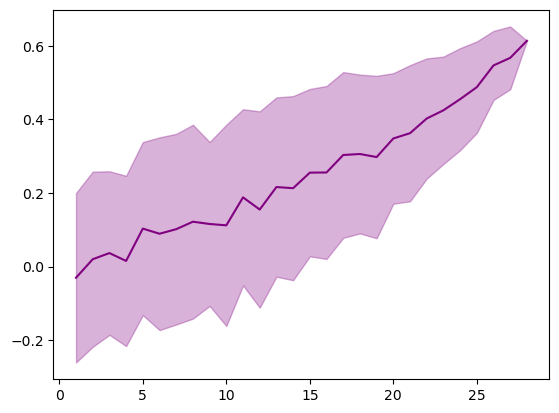

In [287]:
plt.plot(resample_mean.index, resample_mean.adj_r2, c='purple')
plt.fill_between(resample_mean.index, resample_mean.adj_r2-resample_std.adj_r2, 
                 resample_mean.adj_r2+resample_std.adj_r2, alpha=0.3, color='purple')

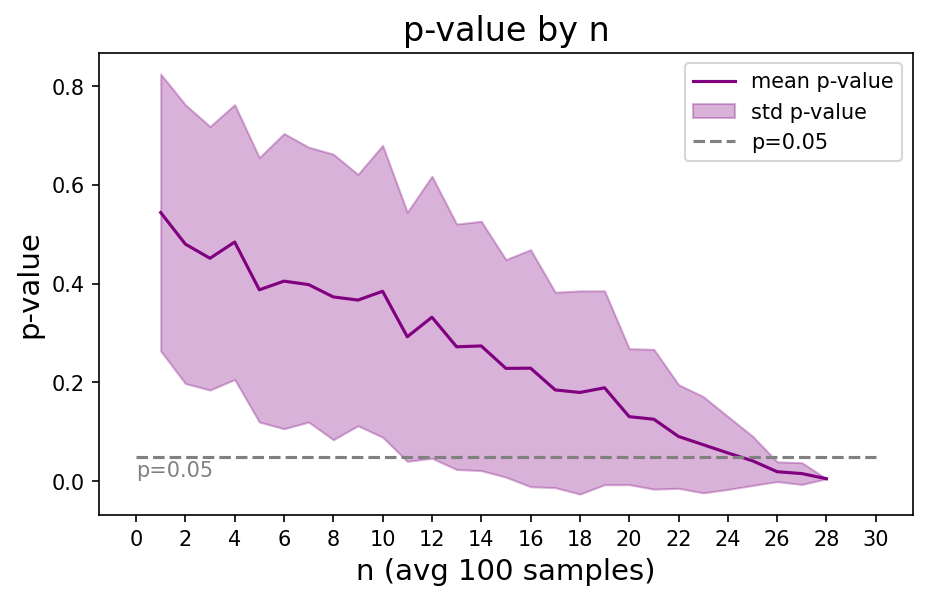

In [291]:
plt.figure(figsize=(7, 4), dpi=150)
# plt.plot(boot_p_df.columns, boot_p_df.mean(), c='purple')
# plt.fill_between(boot_p_df.columns, boot_p_df.mean()-boot_p_df.std(), boot_p_df.mean()+boot_p_df.std(), alpha=0.3, color='purple')
plt.plot(resample_mean.index, resample_mean.pval, c='purple')
plt.fill_between(resample_mean.index, resample_mean.pval-resample_std.pval, 
                 resample_mean.pval+resample_std.pval, alpha=0.3, color='purple')
plt.hlines(0.05, 0, len(subjects), linestyles='dashed', color='grey')
plt.title('p-value by n', fontsize=16)
plt.ylabel('p-value', fontsize=14)
plt.xlabel(f'n (avg {resample_df.shape[0] / resample_mean.shape[0]:.0f} samples)', fontsize=14)
plt.text(0, 0.01, 'p=0.05', fontsize=10, color='grey')
plt.xticks(np.arange(0, 32, 2))
plt.legend(['mean p-value', 'std p-value', 'p=0.05'])

In [292]:
resample_mean.tail(15)

,pval,adj_r2
n,,
14,0.273867,0.213209
15,0.228446,0.255426
16,0.228856,0.255904
17,0.184787,0.303389
18,0.179660,0.306037
19,0.189159,0.297753
20,0.130681,0.348273
21,0.125413,0.362568
22,0.090555,0.402468


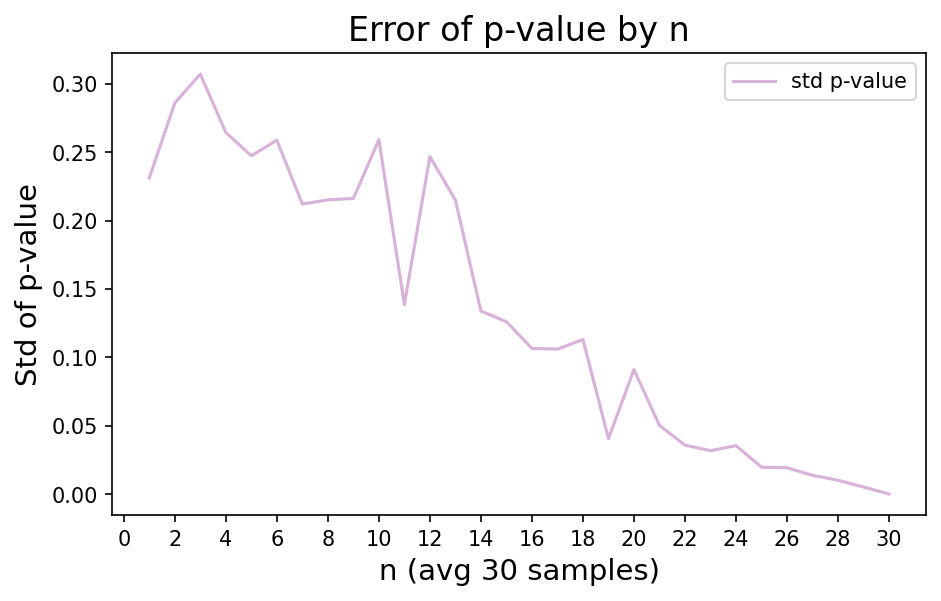

In [ ]:
plt.figure(figsize=(7, 4), dpi=150)
plt.plot(boot_p_df.columns, boot_p_df.std(axis=0), c='purple', alpha=0.3)
plt.title('Error of p-value by n', fontsize=16)
plt.ylabel('Std of p-value', fontsize=14)
plt.xlabel(f'n (avg {boot_p_df.shape[0]} samples)', fontsize=14)
plt.xticks(np.arange(0, 32, 2))
plt.legend(['std p-value'])

In [ ]:
rois_shuffled = list(subject.RDM.keys())
N = 1000
p_arr = np.zeros(N)
r2_arr = np.zeros(N)
for i in tqdm.tqdm(range(N)):
    random.shuffle(rois_shuffled)
    rdm_reg = decoy_subject.RDMRegression(subjects=subjects_missed_filtered, rois=rois_shuffled[:len(stepwise_rois)], sets=set_objs)
    rdm_reg.fit()
    r2_arr[i], p_arr[i] = rdm_reg.adj_r2, rdm_reg.pval

100%|██████████| 1000/1000 [15:33<00:00,  1.07it/s]


In [ ]:
np.mean(p_arr<0.05)

0.246

Text(0.5, 1.0, 'Regression reuslts using 5 random searchlights (N=1000)')

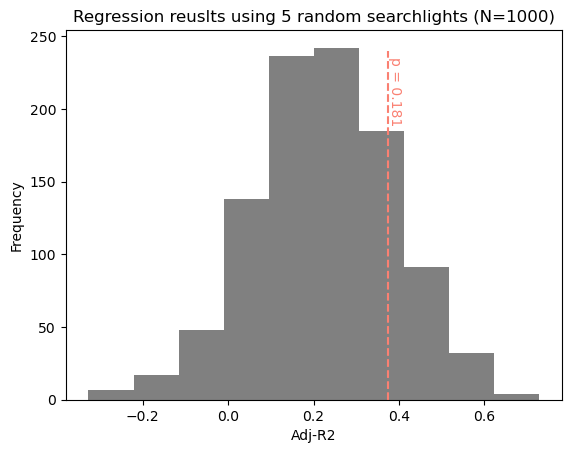

In [ ]:
plt.hist(r2_arr, color='grey')
plt.vlines(0.374, 0, 240, color='salmon', linestyles='dashed')
plt.text(0.374, 190, f'p = {np.mean(r2_arr>=0.374):.3f}', color='salmon', rotation=270)
plt.xlabel('Adj-R2')
plt.ylabel('Frequency')
plt.title('Regression reuslts using 5 random searchlights (N=1000)')